# Текст задания

Нужно сгенерировать 3 cлучайных нелинейных регрессии. Для обоих частей задания зафиксировать размерности 2-3х линейных слоев, их активации, функцию потери, lr и оптимизатор, кол-во эпох. \\
Первая часть задания: протестировать модель только с батчнормом с 3 разными
размерами батча. \\
Вторая часть: протестировать модель с лучшим размером батча из первой части
* без дропаута и без батчнорма,
* только с батчнормом без дропаута,
* только с дропаутом без батчнорма,
* и с батчнормом и с дропаутом.

Визуализировать результаты. \\
В пару предложений записать выводы.

# Код

## Imports

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

## Датасет

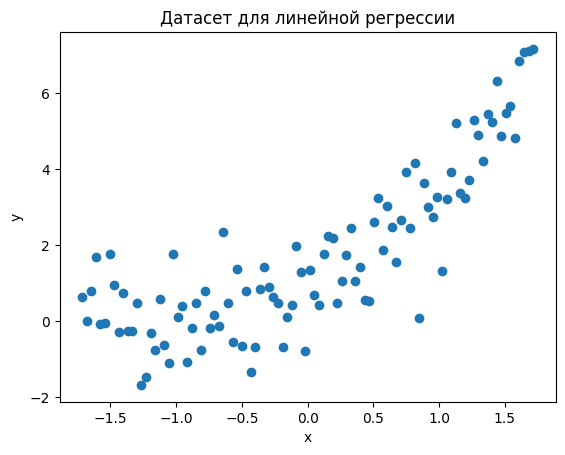

In [245]:
np.random.seed(42)
n_samples = 100

#1
# X = np.linspace(-np.pi, np.pi, n_samples).reshape(-1, 1)
# y = np.cos(X) + np.random.randn(n_samples, 1)

#2
# X = np.linspace(-3, 3, n_samples).reshape(-1, 1)
# y = X**2 + 2 * np.sin(3 * X) + np.random.randn(n_samples, 1)

#3
X = np.linspace(-2, 2, n_samples).reshape(-1, 1)
y = np.exp(X) + np.random.randn(n_samples, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

df = pd.DataFrame({'x': X_scaled.flatten(), 'y': y.flatten()})

plt.scatter(df['x'], df['y'])
plt.title('Датасет для линейной регрессии')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [246]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
dataset = TensorDataset(X_tensor, y_tensor)

In [247]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [248]:
input_size = 1
hidden_size1 = 16
hidden_size2 = 8
output_size = 1
activation = nn.ReLU()
loss_function = nn.MSELoss()
learning_rate = 0.01
optimizer_class = optim.Adam
num_epochs = 100

In [249]:
def create_model(batch_norm=False, dropout=False):
    layers = []
    layers.append(nn.Linear(input_size, hidden_size1))

    if batch_norm:
        layers.append(nn.BatchNorm1d(hidden_size1))

    layers.append(activation)

    if dropout:
        layers.append(nn.Dropout(0.5))

    layers.append(nn.Linear(hidden_size1, hidden_size2))

    if batch_norm:
        layers.append(nn.BatchNorm1d(hidden_size2))

    layers.append(activation)

    if dropout:
        layers.append(nn.Dropout(0.5))

    layers.append(nn.Linear(hidden_size2, output_size))

    return nn.Sequential(*layers)

## Part I

In [250]:
batch_sizes = [16, 32, 64]
results_batch_norm = {}

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

for batch_size in batch_sizes:
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = create_model(batch_norm=True)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        for dx, dy in train_dataloader:
            optimizer.zero_grad()
            outputs = model(dx)
            loss = loss_function(outputs, dy)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())


        model.eval()
        with torch.no_grad():
            for dx_test, dy_test in test_dataloader:
                outputs_test = model(dx_test)
                test_loss = loss_function(outputs_test, dy_test)
                test_losses.append(test_loss.item())

    results_batch_norm[batch_size] = (train_losses, test_losses)

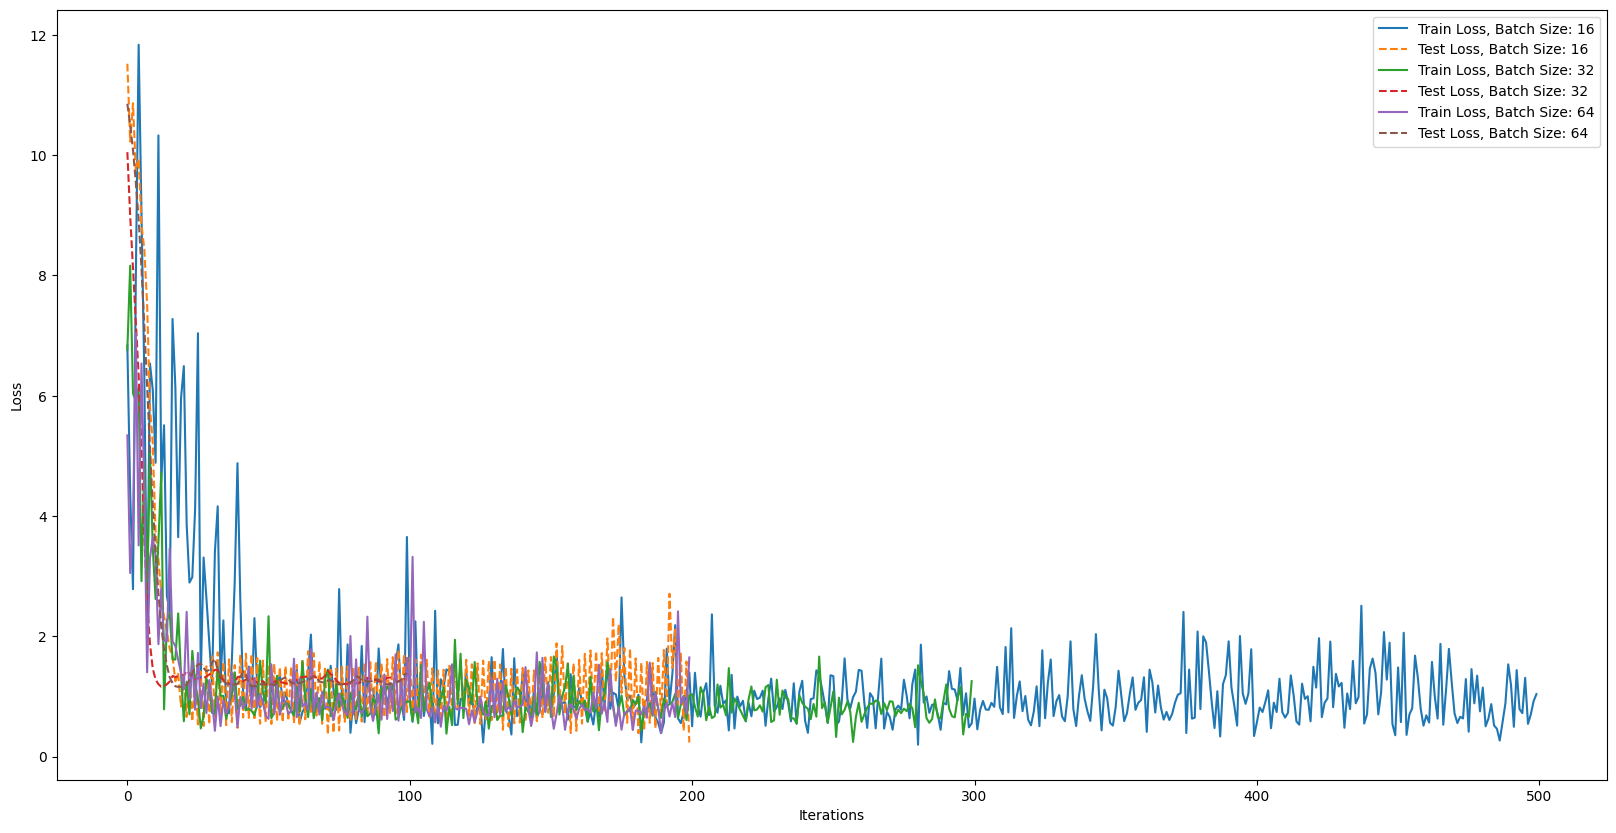

In [251]:
plt.figure(figsize=(20, 10))

for batch_size, (train_losses, test_losses) in results_batch_norm.items():
    plt.plot(train_losses, label=f'Train Loss, Batch Size: {batch_size}')
    plt.plot(test_losses, label=f'Test Loss, Batch Size: {batch_size}', linestyle='--')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Part II

In [252]:
best_batch_size = 64
dataloader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
results_combinations = {}

configurations = {
    'nothing': (False, False),
    'batch norm': (True, False),
    'dropout': (False, True),
    'both': (True, True)
}

for name, (batch_norm, dropout) in configurations.items():
    model = create_model(batch_norm=batch_norm, dropout=dropout)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            for inputs_test, targets_test in test_dataloader:
                outputs_test = model(inputs_test)
                test_loss = loss_function(outputs_test, targets_test)
                test_losses.append(test_loss.item())

    results_combinations[name] = (train_losses, test_losses)

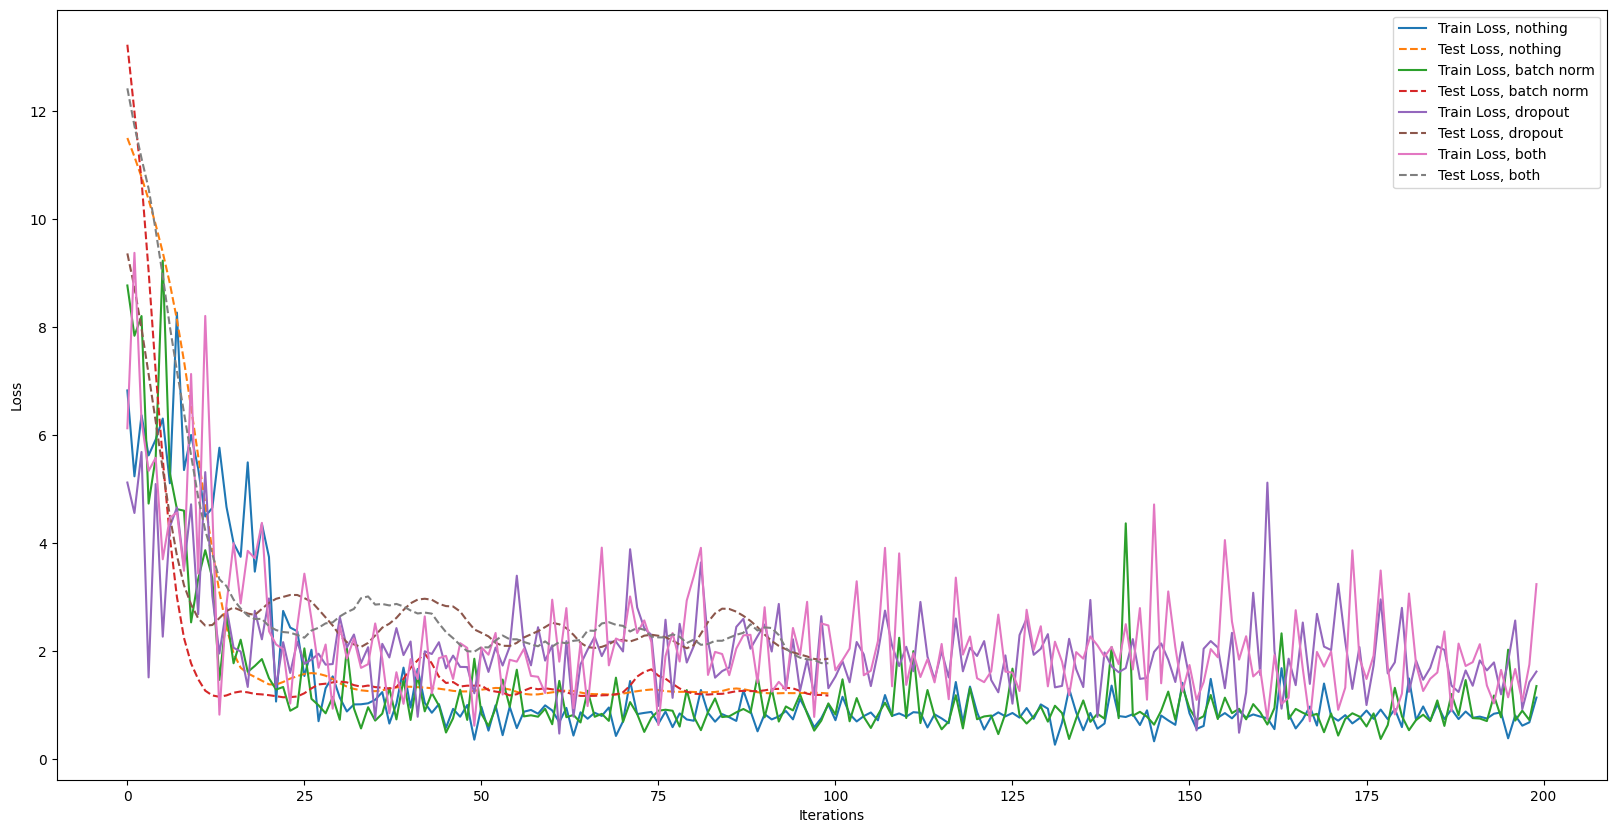

In [253]:
plt.figure(figsize=(20, 10))

for name, (train_losses, test_losses) in results_combinations.items():
    plt.plot(train_losses, label=f'Train Loss, {name}')
    plt.plot(test_losses, label=f'Test Loss, {name}', linestyle='--')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Вывод

C добавлением батч норма и дропаута лосс модели только увеличился. Так как датасет был сгенерирован рандомно и между признаками не существует реальной зависимости, использование этих методов не имеет смысла.